In [1]:
import pandas as pd
from prettypandas import PrettyPandas
import numpy as np

from graphviz import Digraph
import seaborn as sns

import dexpy.factorial
from dexpy.alias import alias_list

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import patches

from IPython.display import display, Markdown, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# dexpy/Design-Expert history

* Initial release 1985, written in Pascal
* Moved to C++ in 1996
* Used Python for some prototyping/validation, but mostly R
* Started using Python with Boost::Python in 2015 for testing components
* Moved to build system to waf (Python) from CMake (DSL)
* Created dexpy in 2016 based on the Design-Expert testing library

# Design of Experiments

A systematic series of tests, in which purposeful changes are made to input factors, so that you may identify causes for significant changes in the output repsonses.

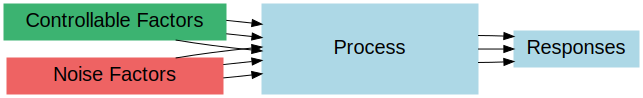

In [2]:
dot = Digraph(comment='Design of Experiments')
dot.body.extend(['rankdir=LR', 'size="10,10"'])
dot.node_attr.update(shape='rectangle', style='filled', fontsize='20', fontname="helvetica")

dot.node('X', 'Controllable Factors', color='mediumseagreen', width='3')
dot.node('Z', 'Noise Factors', color='indianred2', width='3')
dot.node('P', 'Process', color='lightblue', height='1.25', width='3')
dot.node('Y', 'Responses', color='lightblue')

dot.edges(['XP', 'ZP', 'PY'] * 3)

dot

# Traditional Approach to Experimentation

* One factor at a time
* Cannot detect interactions
* Inefficient

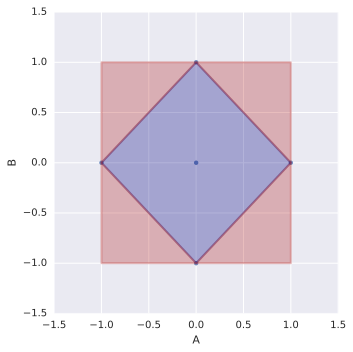

In [3]:
points = [
    [0, 0],
    [-1, 0],
    [1, 0],
    [0, -1],
    [0, 1],
]
df = pd.DataFrame(points, columns=['A', 'B'])
fg = sns.lmplot('A', 'B', data=df, fit_reg=False)

p = patches.Polygon([[-1, 0], [0, 1], [1, 0], [0, -1]], color="navy", alpha=0.3, lw=2)
fg.axes[0, 0].add_patch(p)

p = patches.Polygon([[-1, 0], [-1, 1], [0, 1]], color="firebrick", alpha=0.3, lw=2)
fg.axes[0, 0].add_patch(p)

p = patches.Polygon([[0, 1], [1, 1], [1, 0]], color="firebrick", alpha=0.3, lw=2)
fg.axes[0, 0].add_patch(p)

p = patches.Polygon([[1, 0], [1, -1], [0, -1]], color="firebrick", alpha=0.3, lw=2)
fg.axes[0, 0].add_patch(p)

p = patches.Polygon([[0, -1], [-1, -1], [-1, 0]], color="firebrick", alpha=0.3, lw=2)
p = fg.axes[0, 0].add_patch(p)

# Factorial Design

* Multifactor testing
* Reveals interactions
* Maximizes information with minimum runs

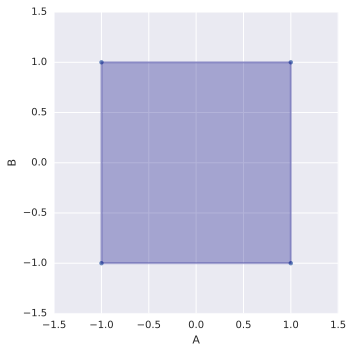

In [4]:
df = dexpy.factorial.build_factorial(2, 4)

fg = sns.lmplot('A', 'B', data=df, fit_reg=False)
p = fg.axes[0, 0].add_patch(patches.Rectangle((-1, -1), 2, 2, color="navy", alpha=0.3, lw=2))

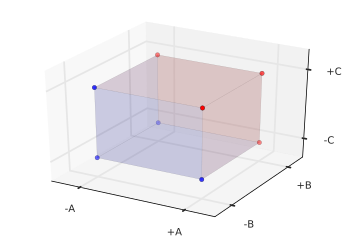

In [11]:
design = dexpy.factorial.build_factorial(4, 8)

points = np.array(design)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d', axisbg='w')
ax.view_init(30, -60) # rotate plot

X, Y = np.meshgrid([-1,1], [-1,1])

cube_alpha = 0.1
ax.plot_surface(X, Y, 1, alpha=cube_alpha, color="r")
ax.plot_surface(X, Y, -1, alpha=cube_alpha)
ax.plot_surface(X, -1, Y, alpha=cube_alpha)
ax.plot_surface(X, 1, Y, alpha=cube_alpha, color="r")
ax.plot_surface(1, X, Y, alpha=cube_alpha, color="r")
ax.plot_surface(-1, X, Y, alpha=cube_alpha)
ax.scatter3D(points[:, 0], points[:, 1], points[:, 2],
             c=["b", "b", "b", "r", "b", "r", "r", "r"])

ax.set_xticks([-1, 1])
ax.set_xticklabels(["-A", "+A"])
ax.set_yticks([-1, 1])
ax.set_yticklabels(["-B", "+B"])
ax.set_zticks([-1, 1])
ax.set_zticklabels(["-C", "+C"])

plt.show()

In [6]:
design = dexpy.factorial.build_factorial(4, 8)
display(Markdown("# Design Matrix:"))
display(PrettyPandas(design))

display(alias_list("(A*B*C*D)**2", design)[0])

# Design Matrix:

['Intercept = A:B:C:D',
 'A = B:C:D',
 'B = A:C:D',
 'A:B = C:D',
 'C = A:B:D',
 'A:C = B:D',
 'B:C = A:D',
 'A:B:C = D']